In [1]:
def encodeText(s, vocab=None, inv_vocab=None):
    """One hot encoding of a text"""
    l_word = s.split()
    #removes punctuation stuck to the words
    l_word = [l_word[i].split('.')[0].split(',')[0].split('(')[0].split(')')[0].split(':')[0].lower() for i in range(0, len(l_word))]
    #removes empty words
    l_word = [l_word[i] for i in range(0, len(l_word)) if len(l_word[i]) > 0]
    set_word = set(l_word)
    vocab_size = len(set_word)
    encoded_text = []
    seen_vocab = 0
    if vocab == None:
        vocab = {}
        inv_vocab = {}
    else:
        vocab_size = len(vocab.keys())
    for i in range(0, len(l_word)):
        word = l_word[i]
        if word not in inv_vocab.keys():
            inv_vocab[word] = [0]*vocab_size
            inv_vocab[word][seen_vocab] = 1
            inv_vocab[word] = tuple(inv_vocab[word])
            vocab[inv_vocab[word]] = word
            seen_vocab += 1
        encoded_text.append(inv_vocab[word])
    return vocab, inv_vocab, encoded_text

def decodeText(l, vocab):
    return " ".join([vocab[l[i]] for i in range(0, len(l))])

print("Test text encode and decode")
vocab, inv_vocab, encoded_text = encodeText("This is a test of a test")
print(encoded_text)
print(vocab)
print(inv_vocab)
print(decodeText(encoded_text, vocab))

Test text encode and decode
[(1, 0, 0, 0, 0), (0, 1, 0, 0, 0), (0, 0, 1, 0, 0), (0, 0, 0, 1, 0), (0, 0, 0, 0, 1), (0, 0, 1, 0, 0), (0, 0, 0, 1, 0)]
{(1, 0, 0, 0, 0): 'this', (0, 1, 0, 0, 0): 'is', (0, 0, 1, 0, 0): 'a', (0, 0, 0, 1, 0): 'test', (0, 0, 0, 0, 1): 'of'}
{'this': (1, 0, 0, 0, 0), 'is': (0, 1, 0, 0, 0), 'a': (0, 0, 1, 0, 0), 'test': (0, 0, 0, 1, 0), 'of': (0, 0, 0, 0, 1)}
this is a test of a test


In [2]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

def textDataset(encoded_text, seq_length):
    """
    Transforms a text in a dataset composed of word sequences of size seq_length.
    The words are encoded as one hot vectors
    """
    data = []
    target = []
    nb_samples = len(encoded_text) - seq_length
    for i in range(0, nb_samples):
        start, end = i, i+seq_length
        data.append(encoded_text[start:end])
        target.append(encoded_text[end].index(1))#not one hot encoding for target : https://github.com/pytorch/pytorch/issues/1258
    return {"data": data, "target": target}

def load(encoded_text, seq_length):
    dataset = textDataset(encoded_text, seq_length)
    return dataset

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def forward(data, target):
    """m, l optimizer and are global"""
    optimizer.zero_grad()
    x = Variable(torch.FloatTensor(data))
    y = Variable(torch.LongTensor(target))
    """foward on the model"""
    out = m(x)
    err = l(out, y)
    return err, out
    
def train(train_dataset, test_dataset, nb_epoch, batch_size):
    list_err = []
    for j in range(0, nb_epoch):
        for i in range(0, (len(train_dataset["data"])//batch_size)*batch_size, batch_size):
            data = train_dataset["data"][i:i+batch_size]
            target = train_dataset["target"][i:i+batch_size]
            err, out = forward(data, target)
            list_err.append(torch.mean(err.data))
            err.backward(retain_graph=True)
            optimizer.step()
        if j%10 == 0:
            print("Epoch : "+str(j))
            test(test_dataset)
    return list_err
         
def test(test_dataset):
    list_test = []
    for i in range(0, len(test_dataset["data"])):
        print("_______________")
        data = [test_dataset["data"][i]]
        target = [test_dataset["target"][i]]
        err, out = forward(data, target)
        print(decodeText(data[0], vocab))
        infered = infer(out[0])
        print(decodeText([infered], vocab))
        list_test.append(torch.mean(err.data))
    print("Test Error : "+str(sum(list_test)/len(list_test)))
    
def show(list_err, nom):
    print("Train Loss "+nom)
    plt.plot(np.arange(0, len(list_err)), list_err)
    plt.show()
    

def infer(out):
    #deduce input from the probability distribution
    res = [0]*len(out)
    m_i = 0
    for i in range(1, len(out)):
        if out.data[i] > out.data[m_i]:
            m_i = i
    res[m_i] = 1
    return tuple(res)

In [9]:
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

class SeqToVect(nn.Module):
    def __init__(self, recurrent_unit):
        nn.Module.__init__(self)
        self.recurrent_unit = recurrent_unit
        
    def forward(self, l):
        ht_minus_1 = Variable(torch.FloatTensor([[0]*len(l[0][0])]*len(l)))
        for i in range(0, len(l[0])):
            ht_minus_1 = self.recurrent_unit(l[:,i], ht_minus_1)
        return ht_minus_1

In [10]:
class RNNRecurrentUnit(nn.Module):
    def __init__(self, size, activation):
        nn.Module.__init__(self)
        self.x_linear = nn.Linear(size, size)
        self.h_linear = nn.Linear(size, size)
        self.activation = activation

    def forward(self, x, ht_minus_1):
        out_x = self.x_linear(x)
        out_h = self.h_linear(ht_minus_1)
        return self.activation(out_x+out_h)
    
class RNN(SeqToVect):
    def __init__(self, size, activation):
        SeqToVect.__init__(self, RNNRecurrentUnit(size, activation))

In [11]:
class LSTMRecurrentUnit(nn.Module):
    """see : https://arxiv.org/pdf/1412.3555v1.pdf"""
    def __init__(self, size,):
        nn.Module.__init__(self)
        self.x_linear_memory_gate_forget = nn.Linear(size, size)
        self.h_linear_memory_gate_forget = nn.Linear(size, size)
        self.c_linear_memory_gate_forget = nn.Linear(size, size)
        self.x_linear_memory_gate_input = nn.Linear(size, size)
        self.h_linear_memory_gate_input = nn.Linear(size, size)
        self.c_linear_memory_gate_input = nn.Linear(size, size)
        self.x_linear_memory = nn.Linear(size, size)
        self.h_linear_memory = nn.Linear(size, size)
        self.x_linear_memory_gate_recall = nn.Linear(size, size)
        self.h_linear_memory_gate_recall = nn.Linear(size, size)
        self.c_linear_memory_gate_recall = nn.Linear(size, size)
        self.c = Variable(torch.FloatTensor([0]*size))

    def forward(self, x, ht_minus_1):
        #memory forget gate
        out_x_memory_gate_forget = self.x_linear_memory_gate_forget(x)
        out_h_memory_gate_forget = self.h_linear_memory_gate_forget(ht_minus_1)
        out_c_memory_gate_forget = self.c_linear_memory_gate_forget(self.c)
        memory_gate_forget = F.sigmoid(out_x_memory_gate_forget+out_h_memory_gate_forget+out_c_memory_gate_forget)
        
        #memory input gate
        out_x_memory_gate_input = self.x_linear_memory_gate_input(x)
        out_h_memory_gate_input = self.h_linear_memory_gate_input(ht_minus_1)
        out_c_memory_gate_input = self.c_linear_memory_gate_input(self.c)
        memory_gate_input = F.sigmoid(out_x_memory_gate_input+out_h_memory_gate_input+out_c_memory_gate_input)
        
        #new memory temp
        out_x_memory = self.x_linear_memory(x)
        out_h_memory = self.h_linear_memory(ht_minus_1)
        new_memory_temp = F.tanh(out_x_memory+out_h_memory)
        
        #new memory
        self.c = memory_gate_forget*self.c + memory_gate_input*new_memory_temp
        
        #memory recall gate
        out_x_memory_gate_recall = self.x_linear_memory_gate_recall(x)
        out_h_memory_gate_recall = self.h_linear_memory_gate_recall(ht_minus_1)
        out_c_memory_gate_recall = self.c_linear_memory_gate_recall(self.c)
        memory_gate = F.sigmoid(out_x_memory_gate_recall+out_h_memory_gate_recall+out_c_memory_gate_recall)
        
        return memory_gate*F.tanh(self.c)

class LSTM(SeqToVect):
    def __init__(self, size):
        SeqToVect.__init__(self, LSTMRecurrentUnit(size))

RNN Test
Epoch : 0
_______________
the rebellion hope to murdered darth
the
Test Error : 4.889167785644531
Epoch : 10
_______________
the rebellion hope to murdered darth
the
Test Error : 4.8833770751953125
Epoch : 20
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.100525856018066
Epoch : 30
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.193421363830566
Epoch : 40
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.095753192901611
Epoch : 50
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.088683128356934
Epoch : 60
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.077367782592773
Epoch : 70
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.0973029136657715
Epoch : 80
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.079586505889893
Epoch : 90
_______________
the rebellion hope to murdered darth
vader
Test Error : 4.

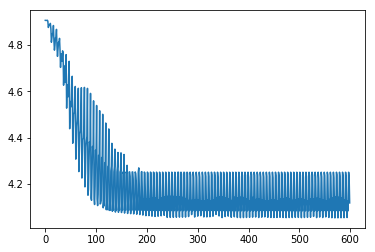

In [12]:
print("RNN Test")
text_train = "Near the orbit of the desert planet Tatooine, a Rebel spaceship is intercepted by the Empire. Aboard, the deadliest Imperial agent Darth Vader and his stormtroopers capture Princess Leia Organa, a secret member of the rebellion. Before her capture, Leia makes sure the astromech R2-D2, along with the protocol droid C-3PO, escapes with stolen Imperial blueprints stored inside and a holographic message for the retired Jedi Knight Obi-Wan Kenobi, who has been living in exile on Tatooine. The droids fall under the ownership of Luke Skywalker, an orphan farm boy raised by his step-uncle and aunt. Luke helps the droids locate Obi-Wan, now a solitary old hermit known as Ben Kenobi, who reveals himself as a friend of Luke's absent father, the Jedi Knight Anakin Skywalker. Obi-Wan confides to Luke that Anakin was betrayed and murdered by Vader (who was Obi-Wan's former Jedi apprentice) years ago, and he gives Luke his father's former lightsaber to keep. After viewing Leia's message, they both hire the smuggler Han Solo and his Wookiee co-pilot Chewbacca to, aboard their space freighter the Millennium Falcon, help them deliver the stolen blueprints inside R2-D2 to the Rebel Alliance with the hope of finding a weakness to the Empire's planet-destroying space station: the Death Star."
text_test = "The rebellion hope to murdered Darth Vader"
vocab, inv_vocab, encoded_text_train = encodeText(text_train)
vocab, inv_vocab, encoded_text_test = encodeText(text_test, vocab, inv_vocab)

batch_size = 30
seq_length = 6
data_train = load(encoded_text_train, seq_length)
data_test = load(encoded_text_test, seq_length)
l = nn.CrossEntropyLoss()
m = RNN(len(vocab.keys()), F.softmax)
#m = LSTM(len(vocab.keys()))
optimizer = torch.optim.Adam(m.parameters(), lr=1e-1)
list_err = train(data_train, data_test, 100, batch_size)
show(list_err, "RNN")